# Generate Mock Data

In this example we generate mock data with a variety of systematic effects including photometric redshifts, source galaxy distributions, and shape noise.  We then populate a galaxy cluster object. This notebooks is organised as follows:
- Imports and configuration setup
- Generate mock data with different source galaxy options
- Generate mock data with different field-of-view options
- Generate mock data with different galaxy cluster options (only available with the Numcosmo and/or CCL backends). Use the `os.environ['CLMM_MODELING_BACKEND']` line below to select your backend.

In [36]:
import os
## Uncomment the following line if you want to use a specific modeling backend among 'ct' (cluster-toolkit), 'ccl' (CCL) or 'nc' (Numcosmo). Default is 'ct'
os.environ['CLMM_MODELING_BACKEND'] = 'nc'

In [37]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make sure we know which version we're using

In [38]:
clmm.__version__

'0.9.2'

## Import mock data module and setup the configuration 

In [79]:
from clmm.support import mock_data as mock
from clmm import Cosmology
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

Mock data generation requires a defined cosmology

In [68]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

In [ ]:
mock_cosmo.eval_da_z1z2(0,cluster_z)

Mock data generation requires some cluster information. The default is to work with the NFW profile, using the "200,mean" mass definition. The Numcosmo and CCL backends allow for more flexibility (see last section of this notebook)

## Generate the mock catalog with different source galaxy options

- Clean data: no noise, all galaxies at the same redshift

In [112]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15 # M200,m
cluster_z = 0.3
src_z = 0.8
concentration = 4 
ngals = 1000 # number of source galaxies
cluster_ra = 0.0
cluster_dec = 0.0
zsrc_min = cluster_z + 0.1 
a = 1.2
dA = mock_cosmo.eval_da_z1z2(0,cluster_z)

In [113]:
ideal_data = mock.generate_galaxy_catalog(
    cluster_m,cluster_z, concentration, cosmo, src_z, ngals=ngals,Delta_SO=200, massdef='mean',halo_profile_model='nfw', zsrc_min=None,
                            zsrc_max=7., field_size=8., shapenoise=0, photoz_sigma_unscaled=None, nretry=5, ngal_density=None)

In [114]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

In [115]:
theta1, g_t1, g_x1 = gc_object.compute_tangential_and_cross_components(geometry="flat")
R = theta1*dA

In [116]:
gc_object

GalaxyCluster CL_ideal: (ra=0.0, dec=0.0) at z=0.3
> 1000 source galaxies
> With columns: ra dec e1 e2 z ztrue id theta et ex

In [117]:
bin_edges = da.make_bins(0.7, 4, 15, method='evenlog10width')

In [118]:
profile_true = gc_object.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

In [119]:
moo_true = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo_true.set_cosmo(mock_cosmo)
moo_true.set_mass(cluster_m) 
moo_true.set_concentration(concentration)

In [120]:
ds_true = moo_true.eval_excess_surface_density(R,cluster_z)

In [125]:
gammat_modified = moo_true.eval_reduced_tangential_shear(R/a, cluster_z, gc_object.galcat['z'])/a**2

In [126]:
gc_object_prolate = gc_object
gc_object_prolate.galcat['et'] = gammat_modified

In [127]:
profile_prolate = gc_object_prolate.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/clmm-0.9.2-py3.7.egg/clmm/galaxycluster.py:298: UserWarning: overwriting profile table.


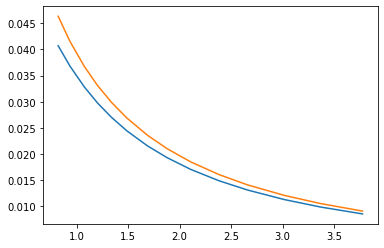

In [128]:
plt.plot(profile_true['radius'], profile_true['gt'])
plt.plot(profile_prolate['radius'], profile_prolate['gt'])